In [1]:
import pandas as pd
import numpy as np
from darts import concatenate, TimeSeries
from darts.dataprocessing.transformers import MinTReconciliator  # noqa
from darts.metrics import mae, rmse, mape  # noqa
from darts.models import (
    LinearRegressionModel,
    NaiveSeasonal,
    ExponentialSmoothing 

)
from darts.utils.model_selection import train_test_split
from darts.utils.utils import ModelMode, SeasonalityMode
from darts.utils.likelihood_models import GaussianLikelihood
import matplotlib.pyplot as plt
from tasks_support_system_ai.utils import get_correct_data_path
from tasks_support_system_ai.readers import read_proper_ts_tree, ts_read_daily_tickets
import seaborn as sns
import random
import matplotlib.cm as cm
from sklearn.ensemble import IsolationForest

In [2]:
import logging

logger = logging.getLogger("cmdstanpy")
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

In [3]:
df = ts_read_daily_tickets(get_correct_data_path("tickets_daily/tickets_daily.csv"))

In [4]:
tree = read_proper_ts_tree(get_correct_data_path("custom_data/tree_proper.csv"))

In [5]:
top_level_tree = tree[(tree["level"] == 1) & (tree["full_load"] != 0)]
top_level_tree.sort_values("full_load", ascending=False)

,queueId,level,immediateDescendants,allDescendants,full_load
7,10,1,"[4472, 472, 4733, 1571, 100118, 2657, 2658, 27...","[10, 104, 462, 472, 1322, 1571, 2190, 2200, 24...",2463146
481,1866,1,"[4307, 4352, 4587, 4667, 4682, 762, 100081, 10...","[762, 1866, 2382, 2733, 3536, 3576, 3617, 3836...",1470013
285,742,1,"[39, 98, 118, 4322, 4412, 2458, 2610, 2921, 3093]","[9, 13, 26, 39, 83, 98, 101, 110, 116, 118, 37...",1387729
26,34,1,"[1, 111, 4522, 842, 1212, 1471, 1531, 1701, 10...","[1, 34, 42, 85, 111, 392, 842, 1212, 1471, 153...",1247019
163,4447,1,"[57, 4457, 4612, 4617, 100254, 100261, 4793, 1...","[57, 382, 1162, 1741, 1881, 1887, 1981, 2007, ...",1121534
485,1871,1,"[4202, 4262, 4723, 100264, 2150, 2170, 2321, 2...","[28, 63, 122, 632, 1062, 1201, 1401, 1871, 198...",1006818
143,4397,1,"[18, 29, 442, 100272, 100042, 2199, 2403, 3750]","[18, 29, 442, 2199, 2240, 2403, 2404, 2535, 32...",986415
90,115,1,"[25, 88, 4547, 4763, 1910, 100044, 100085, 216...","[25, 88, 115, 1910, 2163, 2166, 2219, 2259, 22...",896296
607,2002,1,"[71, 4482, 731, 2226, 2267, 2269, 2298, 2338, ...","[71, 731, 2002, 2226, 2267, 2269, 2298, 2335, ...",825237
41,4147,1,"[7, 14, 4442, 100329, 100034, 100092, 100105, ...","[7, 14, 2544, 3045, 3086, 3095, 3551, 3884, 41...",681754


In [6]:
top_level_queues = list(
    top_level_tree[top_level_tree["full_load"] >= 1300000]["queueId"].values
)
len(top_level_queues), top_level_queues

(3, [10, 742, 1866])

Рассмотрим ТОП-3 очереди по нагруженности

In [7]:
def get_df_slice(queue_id: int):
    queues = tree[tree["queueId"] == queue_id]["allDescendants"].values[0]
    df_slice = df[df["queueId"].isin(queues)].groupby("date")[["new_tickets"]].sum()
    return df_slice

Обработаем аномалии

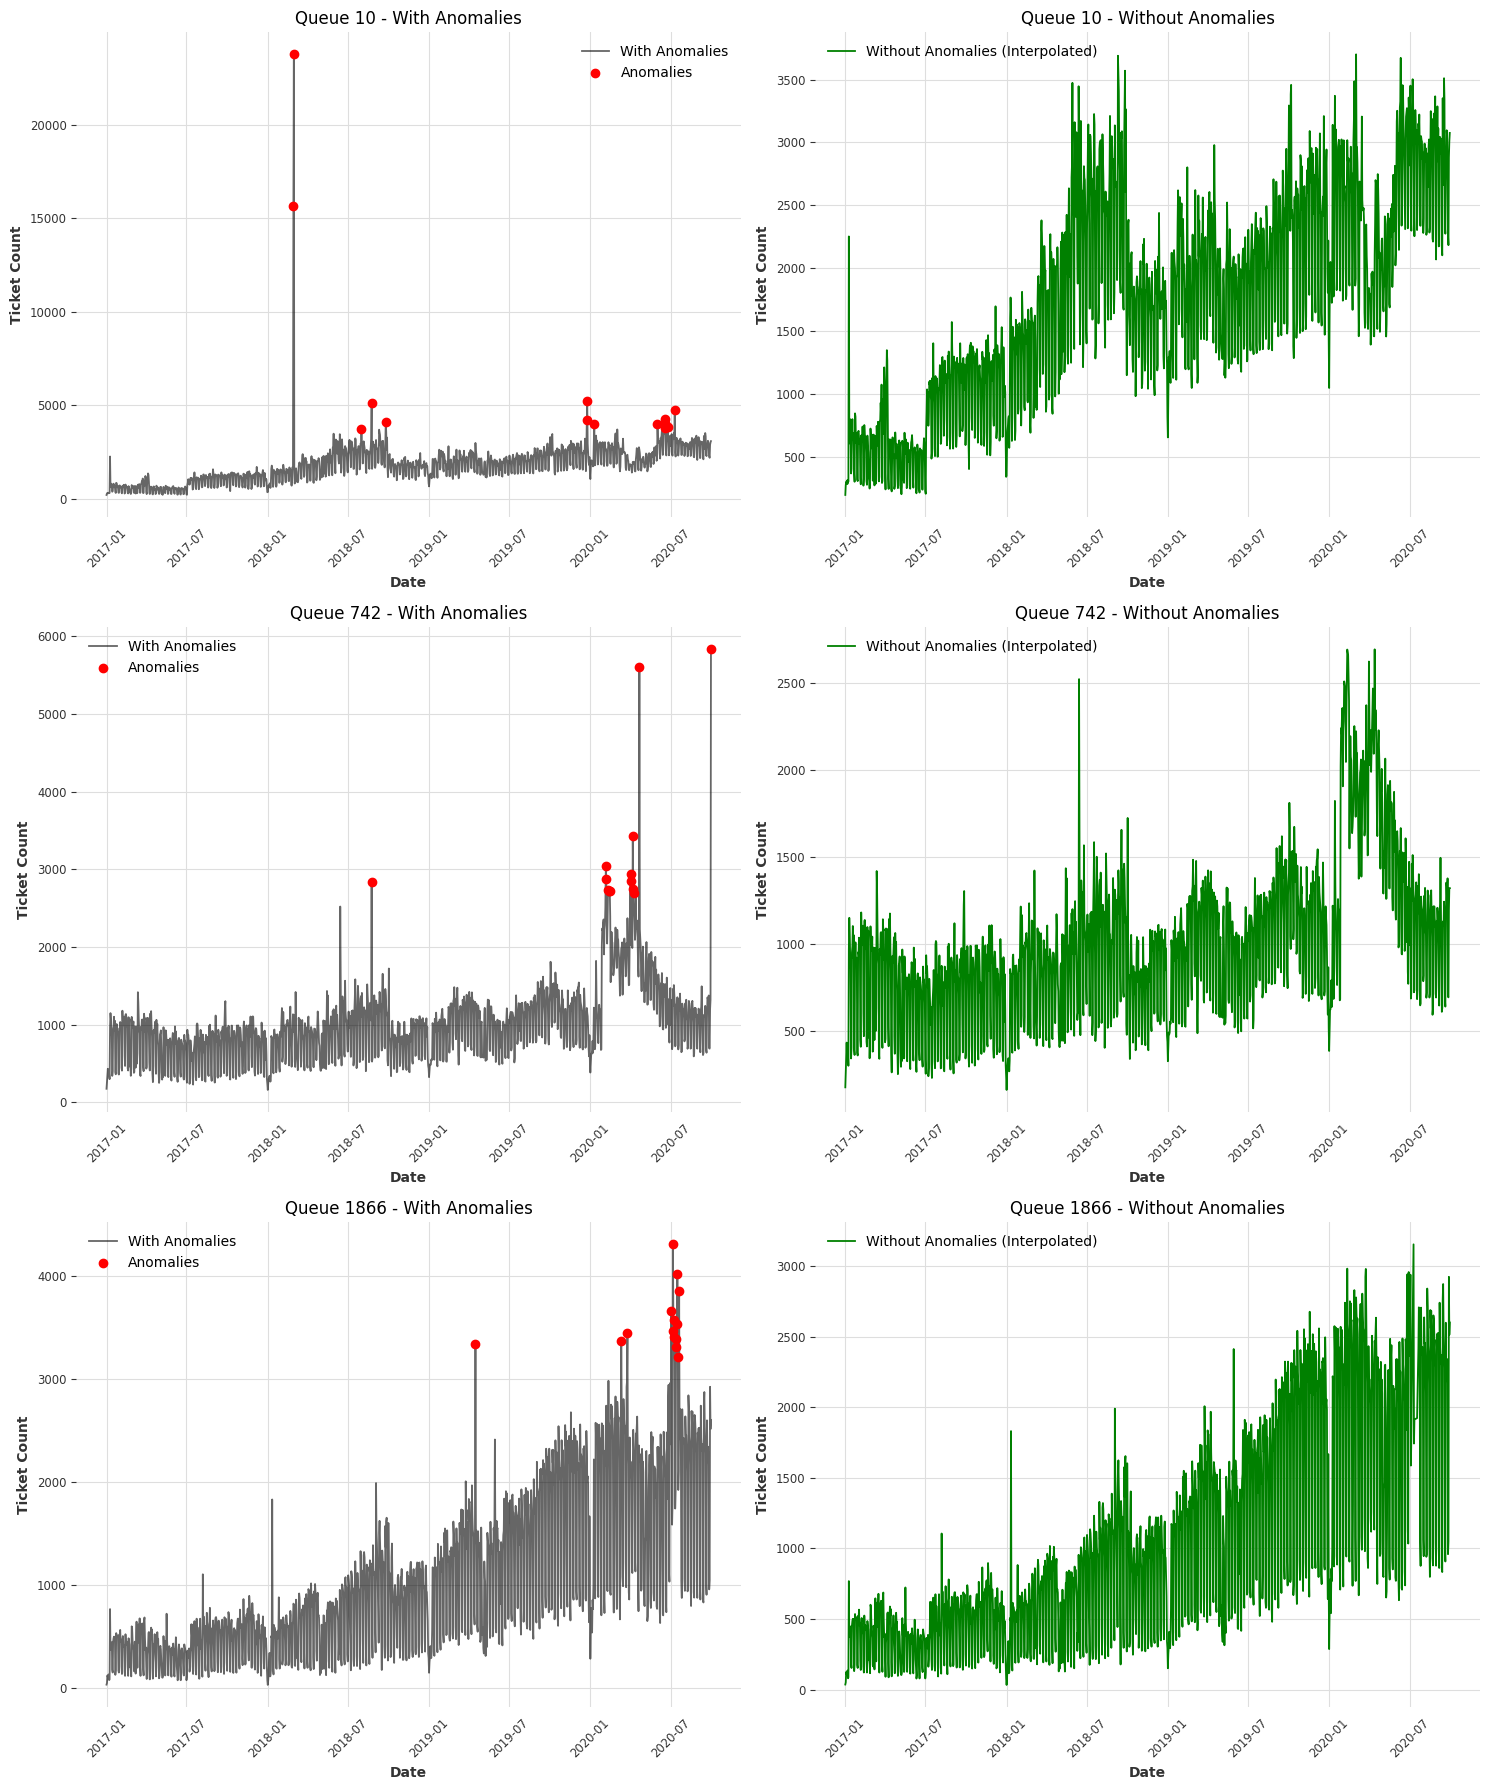

In [8]:
def process_and_plot_anomalies(top_level_queues):
    updated_data = {}  # Словарь для хранения обновленных данных для каждой очереди

    n_cols = 2
    n_queues = len(top_level_queues)
    
    n_rows = (n_queues * 2 + 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 6 * n_rows))
    axes = axes.flatten()

    for idx, queue_id in enumerate(top_level_queues):
        result = get_df_slice(queue_id)
        
        # Находим аномалии с помощью Isolation Forest
        outliers_fraction = 0.01
        model = IsolationForest(contamination=outliers_fraction, random_state=42)
        result["anomaly"] = model.fit_predict(result[["new_tickets"]])

        # Заменяем аномалии линейной интерполяцией
        result["new_tickets_interp"] = result["new_tickets"].copy()
        result.loc[result["anomaly"] == -1, "new_tickets_interp"] = np.nan
        result["new_tickets_interp"] = result["new_tickets_interp"].interpolate(method="linear")

        # Графики
        ax1 = axes[2 * idx]
        ax1.plot(result.index, result["new_tickets"], color="black", label="With Anomalies", linestyle='-', alpha=0.6)
        anomalies = result[result["anomaly"] == -1]
        ax1.scatter(anomalies.index, anomalies["new_tickets"], color="red", label="Anomalies", zorder=5)
        ax1.set_title(f"Queue {queue_id} - With Anomalies", fontsize=12)
        ax1.set_xlabel("Date", fontsize=10)
        ax1.set_ylabel("Ticket Count", fontsize=10)
        ax1.legend()
        ax1.grid(True)
        ax1.tick_params(axis="x", rotation=45)

        ax2 = axes[2 * idx + 1]
        ax2.plot(result.index, result["new_tickets_interp"], color="green", label="Without Anomalies (Interpolated)", linestyle='-')
        ax2.set_title(f"Queue {queue_id} - Without Anomalies", fontsize=12)
        ax2.set_xlabel("Date", fontsize=10)
        ax2.set_ylabel("Ticket Count", fontsize=10)
        ax2.legend()
        ax2.grid(True)
        ax2.tick_params(axis="x", rotation=45)

        updated_data[queue_id] = result

    # Убираем пустые подграфики, если их не хватает
    # for i in range(n_queues * 2, len(axes)):
    #     fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

    return updated_data
        # # Сохраняем результат в файл (если нужно)
        # result.to_csv(f"queue_{queue_id}_processed.csv", index=True)
        
updated_data = process_and_plot_anomalies(top_level_queues)

Воспользуемся grid_search для подбора параметров

In [9]:
def grid_search_regression(X_train, X_test):
    num_lists = 10  
    list_size = 50    
    lower_bound = -100  
    upper_bound = -1    
    model = LinearRegressionModel
    random_lags = [
        [random.randint(lower_bound, upper_bound) for _ in range(list_size)] for _ in range(num_lists)
    ]

    param_grid = {
        "lags": random_lags,
        "output_chunk_length": list(range(1, len(X_test))),
        "multi_models": [True, False],
    }
    
    grid_search_results = model.gridsearch(
        param_grid,
        X_train,
        metric=rmse,
        n_jobs=-1,  #-1 для максимума
        val_series=X_test,
        verbose=5
    )

    return (grid_search_results)

In [10]:
def grid_search_naive_seasonal(X_train, X_test):
    model = NaiveSeasonal

    param_grid = {
        "K": list(range(1, len(X_test)))
    }
    
    grid_search_results = model.gridsearch(
        param_grid,
        X_train,
        metric=rmse,
        n_jobs=-1,  #-1 для максимума
        val_series=X_test,
        verbose=5
    )

    return (grid_search_results)

In [11]:
def grid_search_ES(X_train, X_test):  
    model = ExponentialSmoothing

    param_grid = {
        "trend":[ModelMode.ADDITIVE, ModelMode.MULTIPLICATIVE, ModelMode.NONE],
        "seasonal":[SeasonalityMode.ADDITIVE, SeasonalityMode.MULTIPLICATIVE, SeasonalityMode.NONE],
        "seasonal_periods": list(range(2, len(X_test)))

    }
    
    grid_search_results = model.gridsearch(
        param_grid,
        X_train,
        metric=rmse,
        n_jobs=-1,  #-1 для максимума
        val_series=X_test,
        verbose=5
    )

    return (grid_search_results)

Построим графики для ТОП-3 очередей и сравним работу трех моделей


Analyzing Regression for Queue 10...


  0%|          | 0/6820 [00:00<?, ?it/s]

(LinearRegressionModel(lags=[-81, -47, -22, -9, -62, -88, -76, -28, -99, -60, -16, -32, -38, -26, -100, -55, -65, -83, -71, -3, -21, -70, -11, -65, -63, -76, -4, -88, -3, -21, -25, -38, -52, -76, -97, -11, -96, -79, -78, -72, -73, -37, -5, -90, -25, -90, -26, -52, -94, -66], lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=80, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True), {'lags': [-81, -47, -22, -9, -62, -88, -76, -28, -99, -60, -16, -32, -38, -26, -100, -55, -65, -83, -71, -3, -21, -70, -11, -65, -63, -76, -4, -88, -3, -21, -25, -38, -52, -76, -97, -11, -96, -79, -78, -72, -73, -37, -5, -90, -25, -90, -26, -52, -94, -66], 'output_chunk_length': 80, 'multi_models': True}, 521.9914804937954)

Analyzing Naive Seasonal for Queue 10...


  0%|          | 0/341 [00:00<?, ?it/s]

(NaiveSeasonal(K=7), {'K': 7}, 521.0904140969614)

Analyzing Exponential Smoothing for Queue 10...


  0%|          | 0/3060 [00:00<?, ?it/s]

(ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=266, random_state=0, kwargs=None), {'trend': <ModelMode.ADDITIVE: 'additive'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 266}, 381.7987659385927)
Metrics for Queue 10:
  Model: Regression | RMSE: 270.87 | MAE: 205.34 | MAPE: 9.04
  Model: Naive Seasonal | RMSE: 299.71 | MAE: 225.78 | MAPE: 10.72
  Model: Exponential Smoothing | RMSE: 321.10 | MAE: 255.76 | MAPE: 10.41

Analyzing Regression for Queue 742...


c:\Users\SUBRU\VSCodeProjects\tasks_support_system_ai\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


  0%|          | 0/6820 [00:00<?, ?it/s]

(LinearRegressionModel(lags=[-19, -31, -15, -64, -77, -37, -52, -62, -44, -84, -72, -53, -83, -64, -22, -70, -3, -78, -85, -68, -5, -76, -14, -40, -53, -61, -99, -29, -85, -54, -47, -60, -12, -26, -13, -63, -71, -4, -32, -56, -22, -94, -61, -63, -30, -54, -87, -19, -26, -77], lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=147, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=False, use_static_covariates=True), {'lags': [-19, -31, -15, -64, -77, -37, -52, -62, -44, -84, -72, -53, -83, -64, -22, -70, -3, -78, -85, -68, -5, -76, -14, -40, -53, -61, -99, -29, -85, -54, -47, -60, -12, -26, -13, -63, -71, -4, -32, -56, -22, -94, -61, -63, -30, -54, -87, -19, -26, -77], 'output_chunk_length': 147, 'multi_models': False}, 530.0566638460539)

Analyzing Naive Seasonal for Queue 742...


  0%|          | 0/341 [00:00<?, ?it/s]

(NaiveSeasonal(K=63), {'K': 63}, 499.4143471097825)

Analyzing Exponential Smoothing for Queue 742...


  0%|          | 0/3060 [00:00<?, ?it/s]

(ExponentialSmoothing(trend=ModelMode.NONE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=294, random_state=0, kwargs=None), {'trend': <ModelMode.NONE: None>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 294}, 445.53290160936933)
Metrics for Queue 742:
  Model: Regression | RMSE: 172.90 | MAE: 130.73 | MAPE: 13.05
  Model: Naive Seasonal | RMSE: 224.49 | MAE: 184.10 | MAPE: 14.49
  Model: Exponential Smoothing | RMSE: 230.73 | MAE: 195.99 | MAPE: 15.88

Analyzing Regression for Queue 1866...


  0%|          | 0/6820 [00:00<?, ?it/s]

(LinearRegressionModel(lags=[-6, -78, -90, -28, -63, -79, -17, -41, -77, -65, -77, -10, -52, -96, -29, -5, -70, -89, -63, -75, -72, -42, -53, -55, -39, -67, -99, -95, -49, -12, -62, -15, -29, -94, -75, -100, -36, -25, -61, -55, -39, -18, -46, -74, -79, -82, -6, -5, -10, -70], lags_past_covariates=None, lags_future_covariates=None, output_chunk_length=241, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True), {'lags': [-6, -78, -90, -28, -63, -79, -17, -41, -77, -65, -77, -10, -52, -96, -29, -5, -70, -89, -63, -75, -72, -42, -53, -55, -39, -67, -99, -95, -49, -12, -62, -15, -29, -94, -75, -100, -36, -25, -61, -55, -39, -18, -46, -74, -79, -82, -6, -5, -10, -70], 'output_chunk_length': 241, 'multi_models': True}, 464.01009751855054)

Analyzing Naive Seasonal for Queue 1866...


  0%|          | 0/341 [00:00<?, ?it/s]

(NaiveSeasonal(K=42), {'K': 42}, 418.9706774241612)

Analyzing Exponential Smoothing for Queue 1866...


  0%|          | 0/3060 [00:00<?, ?it/s]

(ExponentialSmoothing(trend=ModelMode.MULTIPLICATIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=7, random_state=0, kwargs=None), {'trend': <ModelMode.MULTIPLICATIVE: 'multiplicative'>, 'seasonal': <SeasonalityMode.ADDITIVE: 'additive'>, 'seasonal_periods': 7}, 385.73481199006545)


c:\Users\SUBRU\VSCodeProjects\tasks_support_system_ai\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Metrics for Queue 1866:
  Model: Regression | RMSE: 308.93 | MAE: 260.46 | MAPE: 17.03
  Model: Naive Seasonal | RMSE: 219.90 | MAE: 160.83 | MAPE: 10.37
  Model: Exponential Smoothing | RMSE: 214.74 | MAE: 139.13 | MAPE: 7.83


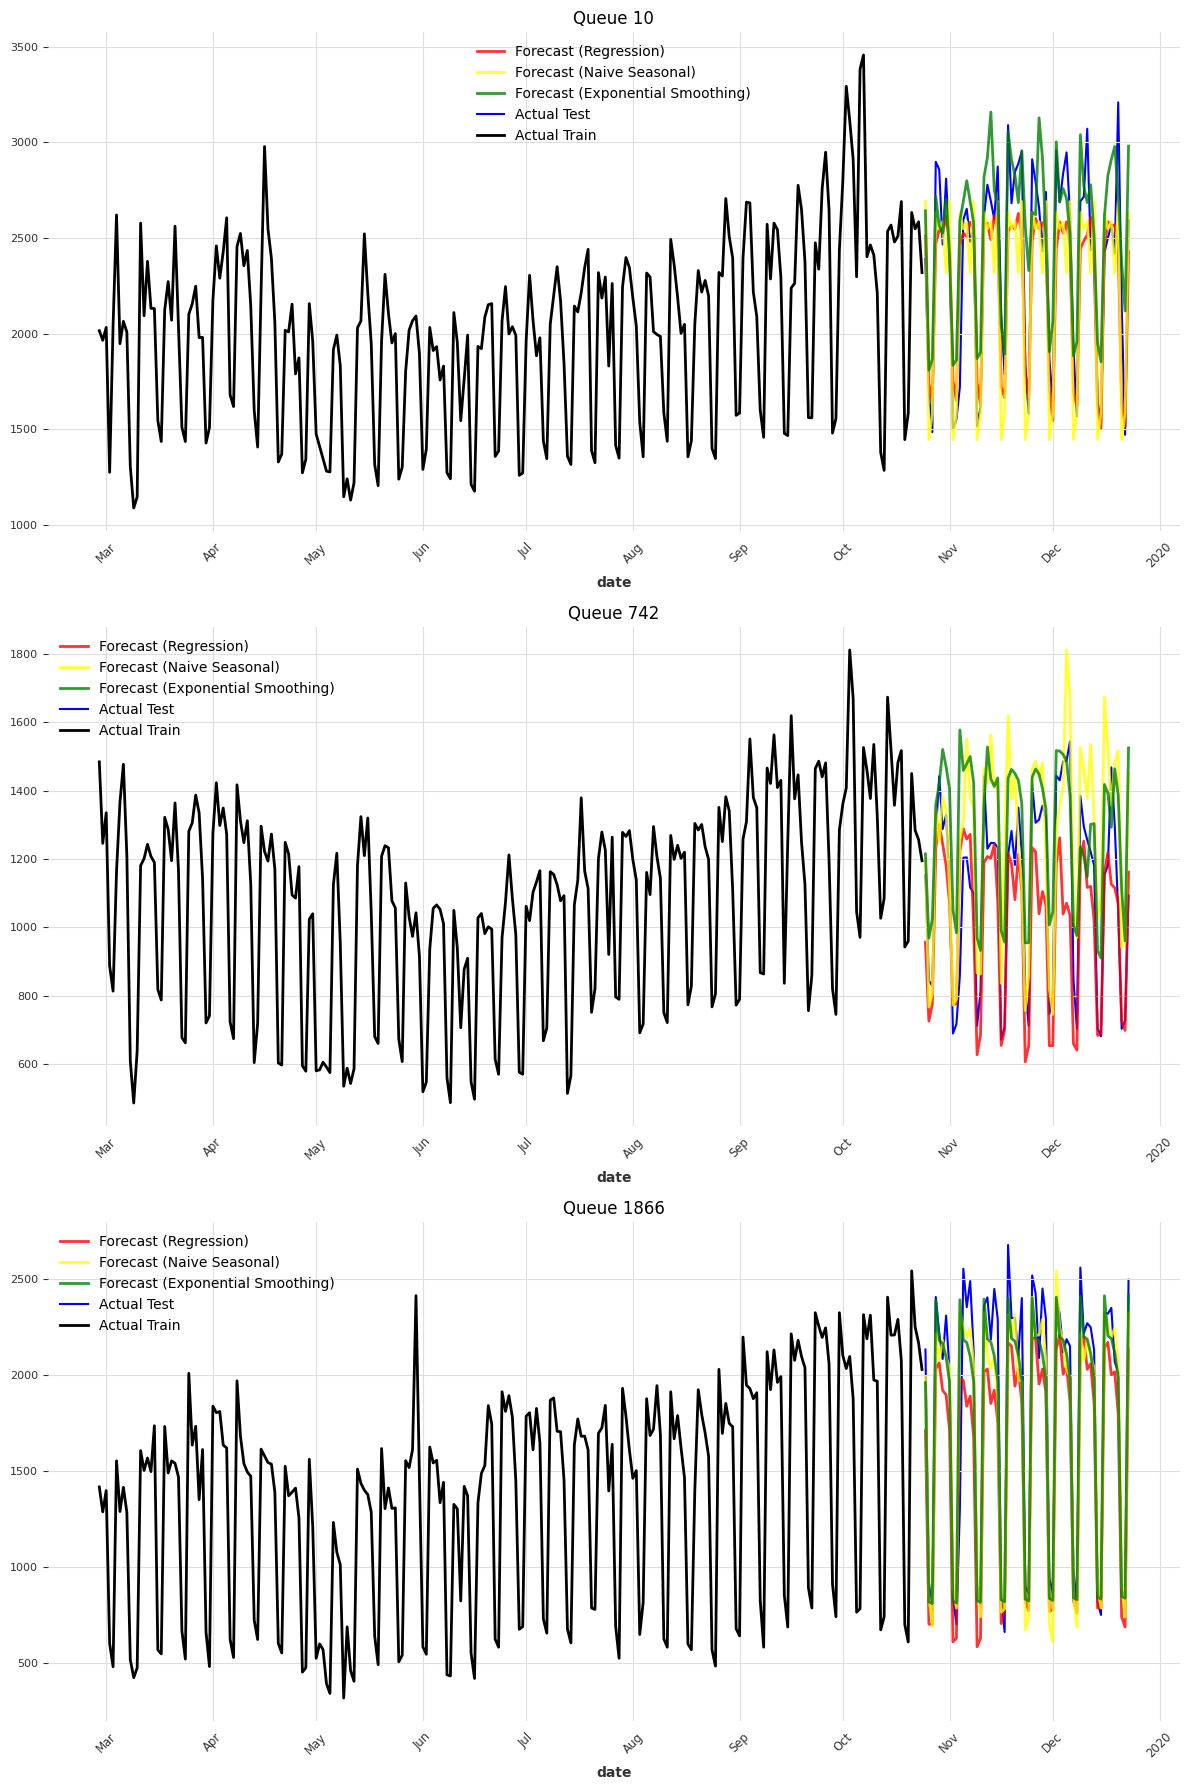

In [12]:
def analyze_queue_performances_combined(
    top_level_queues,
    models_to_try,
    n_rows: int = 3, 
    n_cols: int = 1,
):
    results = {model_name: {} for model_name in models_to_try.keys()}
    model_colors = ["red", "yellow", "green"]

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(12 * n_cols, 6 * n_rows))
    # fig.suptitle("Historical Forecasts by Queue (All Models)", y=0.95, fontsize=16)
    # fig.subplots_adjust(top=5)

    for idx, queue_id in enumerate(top_level_queues):
        ax = axs[idx] if n_rows > 1 else axs  # Получаем текущий график
        result = top_level_queues[queue_id]
        ts = TimeSeries.from_dataframe(
            result,
            value_cols="new_tickets_interp",
            fill_missing_dates=True,
            fillna_value=0,
            freq="D",
        )
        X_train, X_test = train_test_split(ts, test_size=0.25)
        # print(grid_search(X_train, X_test))
        # Словарь для метрик каждой модели
        model_metrics = {}

        for i, (model_name, model_class) in enumerate(models_to_try.items()):
            print(f"\nAnalyzing {model_name} for Queue {queue_id}...")

            # Для линейной регрессии вызываем grid_search для каждой очереди
            if model_name == "Regression":
                optimal_params = grid_search_regression(X_train, X_test)
                print(optimal_params)  # Возвращает параметры, например: lags, output_chunk_length, multi_models

                 #Передаем оптимальные параметры в модель
                model = model_class(
                    lags=sorted(optimal_params[1]['lags']),
                    output_chunk_length=optimal_params[1]['output_chunk_length'],
                    multi_models=optimal_params[1]['multi_models']
                )
            elif model_name == 'Naive Seasonal':
                optimal_params = grid_search_naive_seasonal(X_train, X_test)
                print(optimal_params)  # Возвращает параметры, например: lags, output_chunk_length, multi_models

                 #Передаем оптимальные параметры в модель
                model = model_class(
                    K=optimal_params[1]['K']
                )
            elif model_name == 'Exponential Smoothing':
                optimal_params = grid_search_ES(X_train, X_test)
                print(optimal_params)  # Возвращает параметры, например: lags, output_chunk_length, multi_models

                 #Передаем оптимальные параметры в модель
                model = model_class(
                    trend=optimal_params[1]['trend'],
                    seasonal=optimal_params[1]['seasonal'],
                    seasonal_periods=optimal_params[1]['seasonal_periods']
                )
            else:
                model = model_class
            model.fit(X_train)
            X_pred = model.predict(60)

            RMSE_score = rmse(X_pred, X_test)
            MAE_score = mae(X_pred, X_test)
            MAPE_score = mape(X_pred, X_test)
            model_metrics[model_name] = (RMSE_score, MAE_score, MAPE_score)

            color = model_colors[i % len(model_colors)]

            # Добавляем прогноз модели на график
            X_pred.plot(
                ax=ax,
                label=f"Forecast ({model_name})",
                linestyle="-",
                alpha=0.8,
                color=color,
                zorder=2,  # zorder=2 для размещения поверх тестовых данных
            )
        X_test[:len(X_pred)].plot(ax=ax, label="Actual Test", color="blue", linewidth=1.5, zorder=1)

        X_train[-4*len(X_pred):].plot(ax=ax, label="Actual Train", linestyle="-", color="black", zorder=3)

        # Добавляем заголовок с метриками
        ax.set_title(f"Queue {queue_id}", fontsize=12)
        ax.legend()
        ax.grid(True)
        ax.tick_params(axis="x", rotation=45)
        ax.tick_params(axis="y", labelsize=8)

        print(f"Metrics for Queue {queue_id}:")
        for model_name, (rmse_score, mae_score, mape_score) in model_metrics.items():
            print(
                f"  Model: {model_name} | RMSE: {rmse_score:.2f} | MAE: {mae_score:.2f} | MAPE: {mape_score:.2f}"
            )
    plt.tight_layout()
    plt.show()

    return model_metrics


models_to_try = {
    "Regression": LinearRegressionModel,
    "Naive Seasonal": NaiveSeasonal,
    "Exponential Smoothing": ExponentialSmoothing
}

results = analyze_queue_performances_combined(
    top_level_queues=updated_data,
    models_to_try=models_to_try,
    n_rows=3,
    n_cols=1,
)
